,mask,opacity,acc_rank_delta,quality,final_score
0,circle,170,-310.801200,0.073952,310.875152
1,square,170,-264.897600,0.119989,265.017589
2,circle,140,-203.889200,0.122922,204.012122
3,diamond,170,-188.920400,0.118614,189.039014
4,square,140,-134.754800,0.184646,134.939446
5,circle,110,-113.069200,0.205144,113.274344
6,diamond,140,-90.785200,0.182894,90.968094
7,square,110,-60.570800,0.265004,60.835804
8,circle,80,-52.716800,0.314879,53.031679
9,diamond,110,-39.553600,0.258502,39.812102


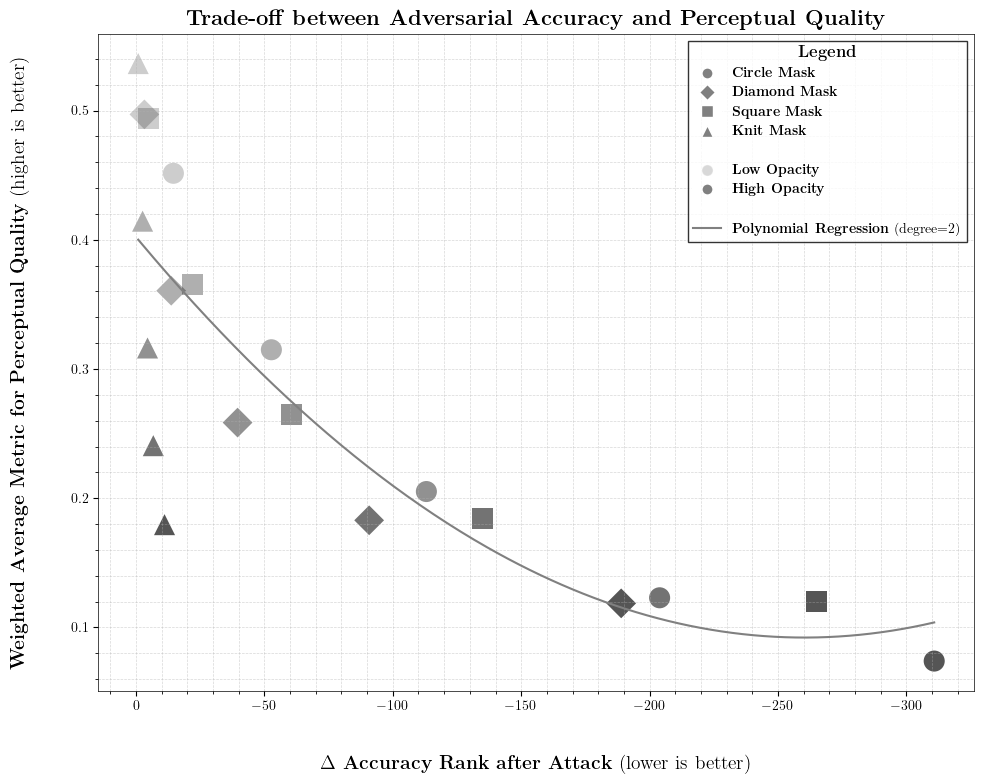

In [103]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})


datapath = Path.cwd().parent / "data" / "eval" / "eval_cls_generalizability.csv"
data = pd.read_csv(datapath)


"""
preprocessing
"""


def get_quality(cs, psnr, ssim, lpips):
    # weighted average metric:
    # - Cosine Similarity: already in the range [-1, 1], can be used as is.
    # - PSNR: normalize to [0, 1] by using a formula like: (PSNR - 30) / 20, clamped to [0, 1].
    # - SSIM: already in the range [-1, 1], can be used as is.
    # - LPIPS: invert and normalize to [0, 1] using: 1 - LPIPS, clamped to [0, 1].

    # create a boolean mask for valid entries
    valid_mask = ~(np.isnan(cs) | np.isnan(psnr) | np.isnan(ssim) | np.isnan(lpips) | np.isinf(cs) | np.isinf(psnr) | np.isinf(ssim) | np.isinf(lpips))

    # initialize with NaN
    wam = pd.Series(np.nan, index=cs.index)

    psnr_n = np.clip((psnr - 30) / 20, 0, 1)

    lpips_n = np.clip(lpips, 0, 1)

    wam[valid_mask] = 0.15 * cs[valid_mask] + 0.25 * psnr_n[valid_mask] + 0.35 * ssim[valid_mask] + 0.25 * (1 - lpips_n[valid_mask])

    return wam


data["acc_rank_delta"] = data["acc_rank"] - data["adv_acc_rank"]  # before - after (lower is better)
data["quality"] = get_quality(data["cosine_sim"], data["psnr"], data["ssim"], data["lpips"])
data["final_score"] = data["quality"] - data["acc_rank_delta"]  # higher is better

data = data.drop(columns=["model", "density", "img_id", "acc_rank", "adv_acc_rank", "cosine_sim", "psnr", "ssim", "lpips"])

data = data.groupby(["mask", "opacity"]).agg({"acc_rank_delta": "mean", "quality": "mean", "final_score": "mean"}).reset_index()


data = data.sort_values(by="final_score", ascending=False)
data = data.reset_index(drop=True)
display(data)


"""
plot
"""


plt.figure(figsize=(10, 8))

adv_acc = data["acc_rank_delta"]  # x-axis
quality = data["quality"]  # y-axis

plt.gca().invert_xaxis()

mask = data["mask"]  # "mask": ["circle", "square", "diamond", "knit"],
opacity = data["opacity"]  # "opacity": [50, 80, 110, 140, 170],

markers = {"circle": "o", "square": "s", "diamond": "D", "knit": "^"}

for mask in markers:
    mask_data = data[data["mask"] == mask]
    plt.scatter(mask_data["acc_rank_delta"], mask_data["quality"], marker=markers[mask], c="black", alpha=mask_data["opacity"] / 255, s=230, edgecolors="none")

# polynomial regression
x = data["acc_rank_delta"].values.reshape(-1, 1)
y = data["quality"].values
degree = 2
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(x, y)
x_smooth = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
y_smooth = polyreg.predict(x_smooth)
plt.plot(x_smooth, y_smooth, color="gray")


plt.title(r"\textbf{Trade-off between Adversarial Accuracy and Perceptual Quality}")
plt.xlabel(r"\textbf{$\Delta$ Accuracy Rank after Attack} (lower is better)")
plt.ylabel(r"\textbf{Weighted Average Metric for Perceptual Quality} (higher is better)")
# increase padding between label and axis
plt.gca().yaxis.labelpad = 30
plt.gca().xaxis.labelpad = 30

legend_elements = [
    plt.Line2D([0], [0], marker="o", color="w", label=r"\textbf{Circle Mask}", markerfacecolor="gray", markersize=8),
    plt.Line2D([0], [0], marker="D", color="w", label=r"\textbf{Diamond Mask}", markerfacecolor="gray", markersize=8),
    plt.Line2D([0], [0], marker="s", color="w", label=r"\textbf{Square Mask}", markerfacecolor="gray", markersize=8),
    plt.Line2D([0], [0], marker="^", color="w", label=r"\textbf{Knit Mask}", markerfacecolor="gray", markersize=8),
    plt.Line2D([0], [0], marker='None', color='w', label=''),
    plt.Line2D([0], [0], marker='o', color='w', label=r"\textbf{Low Opacity}", markerfacecolor='gray', markersize=8, alpha=0.3),
    plt.Line2D([0], [0], marker='o', color='w', label=r"\textbf{High Opacity}", markerfacecolor='gray', markersize=8, alpha=1),
    plt.Line2D([0], [0], marker="None", color="w", label=""),
    plt.Line2D([0], [0], color="gray", label=r"\textbf{Polynomial Regression} (degree=" + str(degree) + ")", linewidth=1.5),
]

plt.legend(handles=legend_elements, title=r"\textbf{Legend}", loc="upper right", frameon=True, fancybox=False, edgecolor="black")

plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
plt.minorticks_on()
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())

for spine in plt.gca().spines.values():
    spine.set_linewidth(0.5)

plt.tight_layout()
# plt.savefig("academic_plot.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()